# Simuation based Infernce on K_bath params

In [1]:
import os
import time

import numpy as np
import numba
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy as scp

from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
from scipy.stats import entropy

import torch
import sbi
from sbi.inference.base import infer
from sbi import inference
import sbi.utils as utils
from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Numpy version: {np.__version__}")
print(f"Numba version: {numba.__version__}")
print(f"SciPy version: {scp.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Matplotlib` version: {matplotlib.__version__}")
print(f"SBI version: {sbi.__version__}")

Numpy version: 1.26.4
Numba version: 0.59.1
SciPy version: 1.13.0
Torch version: 2.3.0
Matplotlib` version: 3.9.0
SBI version: 0.22.0


In [3]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
cwd = os.getcwd()
cwd

'/Users/gianmarcocafaro/Desktop'

In [5]:
Res_dir_post_distr = 'SBI_K_bath_100_Sel_5/Posterior_distr'
Res_dir_reg = 'SBI_K_bath_100_Sel_5/regression'
Res_dir_time_series = 'SBI_K_bath_100_Sel_5/time_series'
Res_dir_data = 'SBI_K_bath_100_Sel_5/data'

### Data features

In [6]:
import import_ipynb
from function_for_features import events_counter, features_series, Peak_pos

importing Jupyter notebook from function_for_features.ipynb


In [7]:
mode = ['ISI_ave_serie','Num_burst','Num_of_spikes']

In [8]:
def calculate_summary_statistics(v,th,mode='all'):
    peak_pos = Peak_pos(v)
    events = events_counter(peak_pos,th)
    fetures_dict = features_series(events,v,peak_pos,mode)
    N = len(fetures_dict)
    features = np.zeros(N)
    i = 0
    for t in fetures_dict:
        features[i] = fetures_dict[t]
        i += 1
    return features

### K_bath Model

In [9]:
def Kbath_ode_model(params):
    t_init = 0
    t_final = 10000
    dt = 0.01
    gamma=0.04
    epsilon=0.01
    ts = np.arange(t_init,t_final,dt)
    v_0 = -78.0
    n_inf = 1.0 / (1.0 + np.exp((-19.0 - v_0) / 18.0))
    z0 = np.array([-78.0, n_inf, -0.6, 0.8])
    Np = 10000
    t = np.linspace(0, Np, int(Np / 0.01))
    v = np.zeros_like(t)
    n = np.zeros_like(t)
    DK_i = np.zeros_like(t)
    Kg = np.zeros_like(t)
    Cm = 1.0
    tau_n = 0.25

    w_i = 2160.
    w_o = 720.
    rho = 250.
    beta = w_i / w_o

    K_bath = params

    Na_i0 = 16.0
    Na_o0 = 138.0
    K_i0 = 140.0
    K_o0 = 4.80
    Cl_o0 = 112.0
    Cl_i0 = 5.0
    g_Cl = 7.5
    g_Na = 40.0
    g_K = 22.0
    g_Nal = 0.02
    g_Kl = 0.12
    v[0] = z0[0]
    n[0] = z0[1]
    DK_i[0] = z0[2]
    Kg[0] = z0[3]

    for i in range(1, ts.shape[0]):
        DNa_i = -DK_i[i - 1]
        DNa_o = -beta * DNa_i
        DK_o = -beta * DK_i[i - 1]
        K_i = K_i0 + DK_i[i - 1]
        Na_i = Na_i0 + DNa_i
        Na_o = Na_o0 + DNa_o
        K_o = K_o0 + DK_o + Kg[i - 1]

        m_inf = 1.0 / (1.0 + np.exp((-24.0 - v[i - 1]) / 12.0))
        n_inf = 1.0 / (1.0 + np.exp((-19.0 - v[i - 1]) / 18.0))
        h_n = 1.1 - 1.0 / (1.0 + np.exp(-8.0 * (n[i - 1] - 0.4)))

        I_Na = (g_Nal + g_Na * m_inf * h_n) * (v[i - 1] - 26.64 * np.log(Na_o / Na_i))
        I_K = (g_Kl + g_K * n[i - 1]) * (v[i - 1] - 26.64 * np.log(K_o / K_i))
        I_Cl = g_Cl * (v[i - 1] + 26.64 * np.log(Cl_o0 / Cl_i0))
        I_pump = rho * (1.0 / (1.0 + np.exp((21.0 - Na_i) / 2.0))) * (1.0 / (1.0 + np.exp((5.5 - K_o))))

        dv = (-1.0 / Cm) * (I_Cl + I_Na + I_K + I_pump)
        dn = (n_inf - n[i - 1]) / tau_n
        dDK_i = -(gamma / w_i) * (I_K - 2.0 * I_pump)
        dKg = epsilon * (K_bath - K_o)

        v[i] = v[i - 1] + dt * dv
        n[i] = n[i - 1] + dt * dn
        DK_i[i] = DK_i[i - 1] + dt * dDK_i
        Kg[i] = Kg[i - 1] + dt * dKg

    return np.concatenate((v, n, DK_i, Kg))

In [10]:
Kbath_ode_model_jit = jit(Kbath_ode_model)

### Model Wrapper

In [11]:
def Kbath_model_Wrapper(params):

    params_ = np.asarray(params)
    V = -78.0
    n_inf = 1.0 / (1.0 + np.exp((-19.0 - V) / 18.0))
    z0 = np.array([V, n_inf, -0.6, 0.8])
    t_init = 0
    t_final = 10000
    dt = 0.01
    
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]

    v = Kbath_ode_model_jit(params_[0])[0:nt]
    
    summstats = torch.as_tensor(calculate_summary_statistics(v.reshape(-1), th= 0.00012,mode = mode))
    
    return summstats

### Prior

In [12]:
prior_min = [7.5]
prior_max = [22.0]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [13]:
prior.sample()   

tensor([13.4306])

In [14]:
prior.sample().tolist()

[10.189515113830566]

In [15]:
prior_samples=np.stack([prior.sample().tolist() for _ in range(100)], axis=0)
prior_samples.shape

(100, 1)

In [16]:
num_params=prior.sample().shape[0]
num_params

1

In [17]:
num_sims=100

### SBI

In [18]:
start_time = time.time()
posterior = infer(Kbath_model_Wrapper, prior, method='SNPE', num_simulations=num_sims, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100 simulations.: 100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


 Neural network successfully converged after 117 epochs.------------------------------------------------------------
--- 249.57634806632996 seconds ---


In [19]:
params_label=np.array(['$\K$'])

Plot the membrane potential v and firing rate r

In [20]:
v_0 = -78.0
n_inf = 1.0 / (1.0 + np.exp((-19.0 - v_0) / 18.0))
z0 = [-78.0, n_inf, -0.6, 0.8]
t_init = 0
t_final = 10000
dt = 0.01
ts = np.arange(t_init,t_final,dt)
nt=ts.shape[0]

In [21]:
def Posterior_obs(K_true,plot=False):
    true_params = np.array([K_true])
    x_obs = Kbath_ode_model_jit(true_params[0])
    v_obs=x_obs[0:nt]
    r_obs=x_obs[nt:2*nt]
    x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), th= 0.00012,mode=mode)
    num_samples=10000
    start_time = time.time()

    posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

    print ("-"*60)
    print("--- posterior sampling took: %s seconds ---" % (time.time() - start_time))
    K_est= posterior_samples[:,0]

    K_est_mean = np.mean(posterior_samples[:,0])
    K_est_std = np.std(posterior_samples[:,0])

    if plot is True:
        "plotting distplot"
        plt.figure(figsize=(16, 4))
        for i in range (num_params): 
            ax = plt.subplot(1, 3, i + 1)
            ax=sns.distplot(posterior_samples[:,i], bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                        kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                        hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                        label='SBI')

            x_ = ax.lines[0].get_xdata()
            y_ = ax.lines[0].get_ydata()
            ymax = max(y_)
            xpos = np.argmax(y_, axis=0)
            xmax = x_[xpos]
            plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
            plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

            plt.xlabel('K', fontsize=20)   
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.title(f'K_true = {K_true:.2f}')

            if i==0:
                plt.ylabel(' Posterior ', fontsize=18);  
            else:
                plt.ylabel('')
                
            if i==2:
                    plt.legend(fontsize=16, frameon=False)
        
        plt.tight_layout(pad=1.0)
        plt.savefig(os.path.join(cwd+'/'+str(Res_dir_post_distr),"SBI_posterior_KDEplot_allfeatures_100sims_ObsI"+"K_true="+str(K_true)+".png"), dpi=800)
        plt.savefig(os.path.join(cwd+'/'+str(Res_dir_post_distr),"SBI_posterior_KDEplot_allfeatures_100sims_ObsI"+"K_true="+str(K_true)+".eps"), dpi=800)
        plt.show()


        plt.figure(figsize=(16, 4))
        for i in range (num_params): 
            ax = plt.subplot(1, 3, i + 1)
            
        
            ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                        kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "Posterior"})
            
            ax_=sns.distplot(prior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                        kde_kws={"color": "g", "alpha": 0.9, "lw": 3, "label": "Prior"})

            x_ = ax.lines[0].get_xdata()
            y_ = ax.lines[0].get_ydata()
            ymax = max(y_)
            xpos = np.argmax(y_, axis=0)
            xmax = x_[xpos]
            plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
            plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

            plt.xlabel('K', fontsize=20)   
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.title(f'K_true = {K_true:.2f}')

            if i==0:
                plt.ylabel(' Posterior ', fontsize=18);  
            else:
                plt.ylabel('')
                
            if i==2:
                    plt.legend(fontsize=16, frameon=False)
        
        plt.tight_layout(pad=1.0)
        plt.savefig(os.path.join(cwd+'/'+str(Res_dir_post_distr),"SBI_posterior_PriorPosteriorplot_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".png"), dpi=800)
        plt.savefig(os.path.join(cwd+'/'+str(Res_dir_post_distr),"SBI_posterior_PriorPosteriorplot_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".eps"), dpi=800)
        plt.show()

    return K_est_mean,K_est_std
    
    

Drawing 10000 posterior samples: 12004it [00:00, 189810.69it/s]           


------------------------------------------------------------
--- posterior sampling took: 0.06445121765136719 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


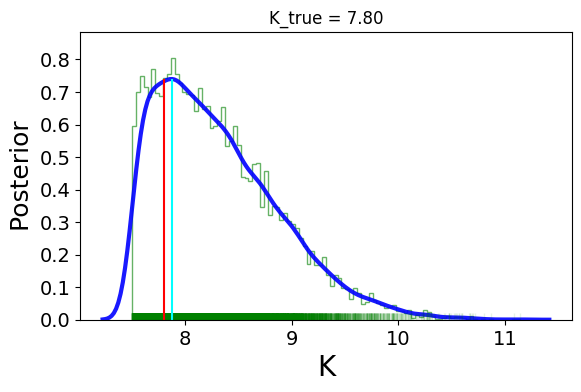

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


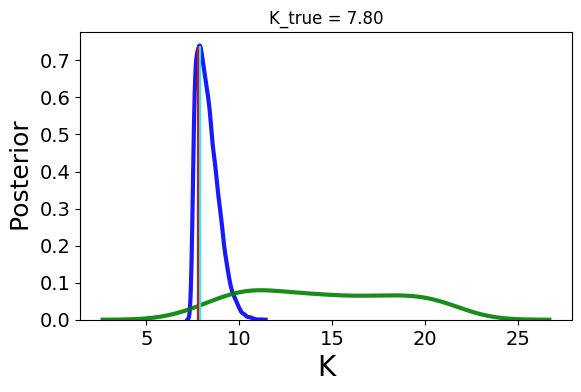

mean =  8.312417  std =  0.58047354


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 296268.59it/s]


------------------------------------------------------------
--- posterior sampling took: 0.03504467010498047 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


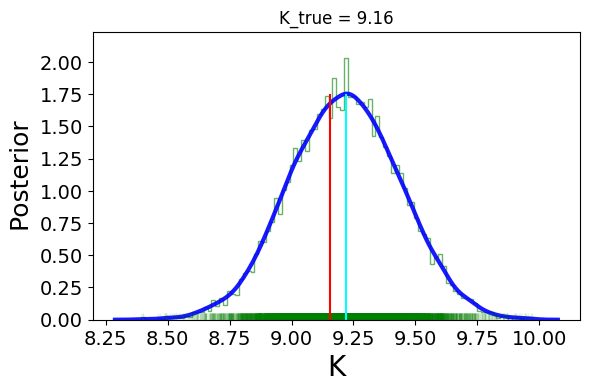

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


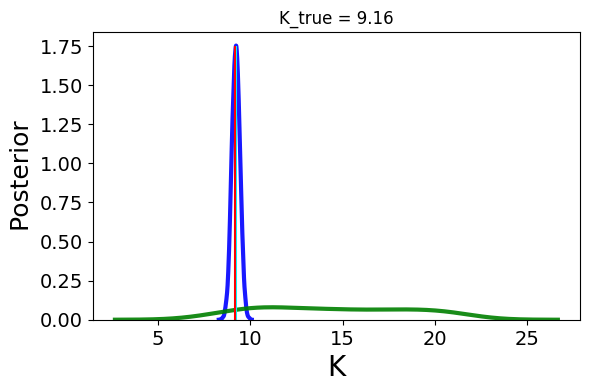

mean =  9.2153015  std =  0.22348955


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 322207.51it/s]


------------------------------------------------------------
--- posterior sampling took: 0.03221917152404785 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


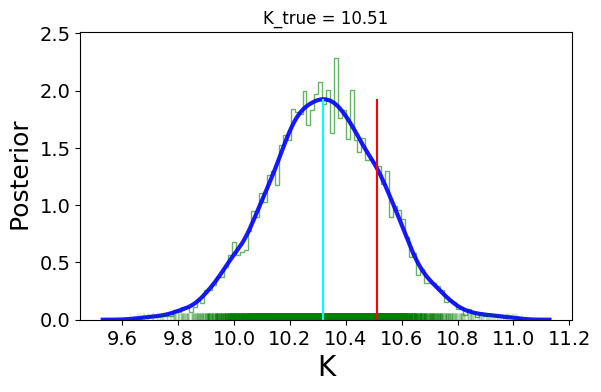

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


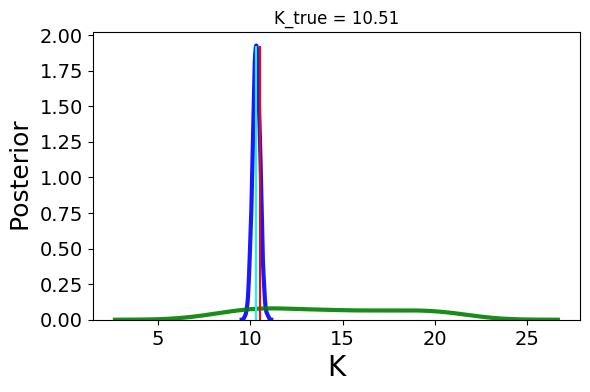

mean =  10.324873  std =  0.20382988


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 328568.16it/s]


------------------------------------------------------------
--- posterior sampling took: 0.031566619873046875 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


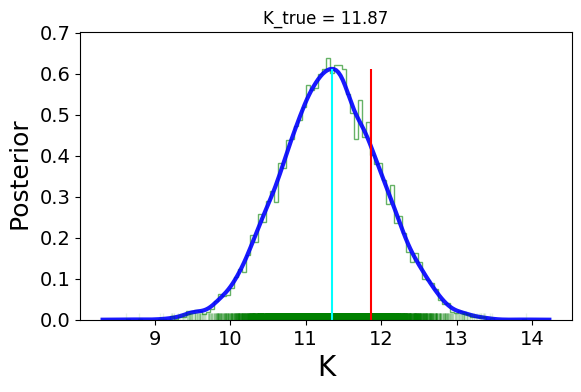

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


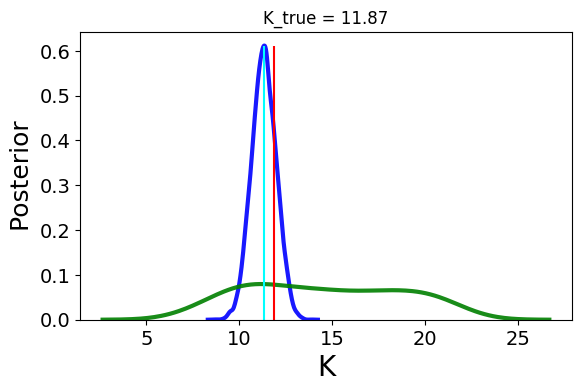

mean =  11.325656  std =  0.659108


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 306475.71it/s]


------------------------------------------------------------
--- posterior sampling took: 0.033956050872802734 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


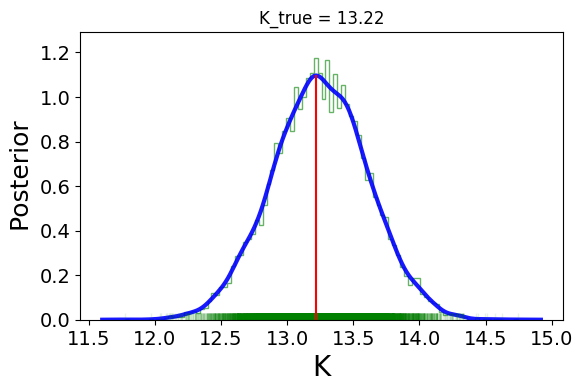

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


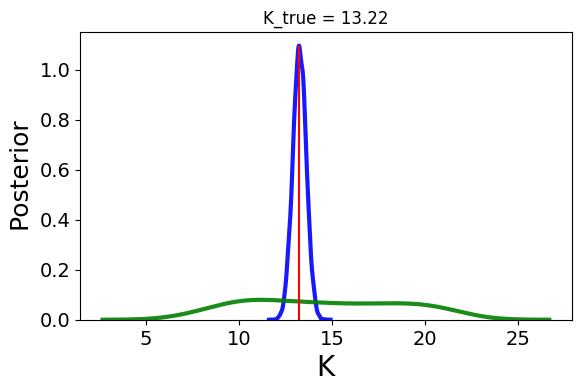

mean =  13.249481  std =  0.36272767


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 337019.12it/s]


------------------------------------------------------------
--- posterior sampling took: 0.030848979949951172 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


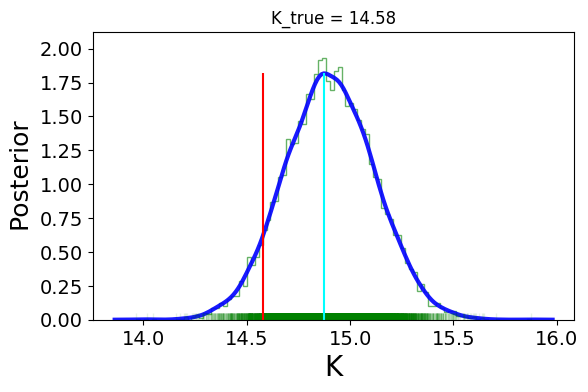

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


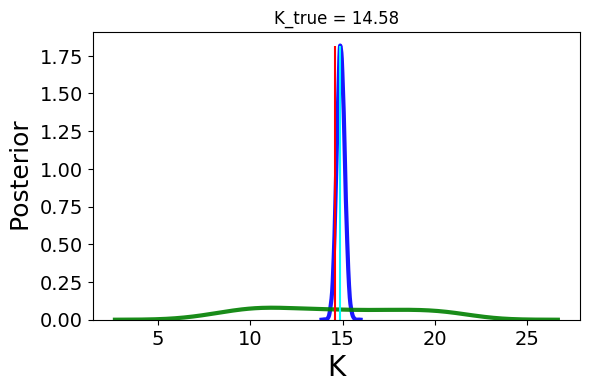

mean =  14.901075  std =  0.21910205


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 320533.11it/s]


------------------------------------------------------------
--- posterior sampling took: 0.03243088722229004 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


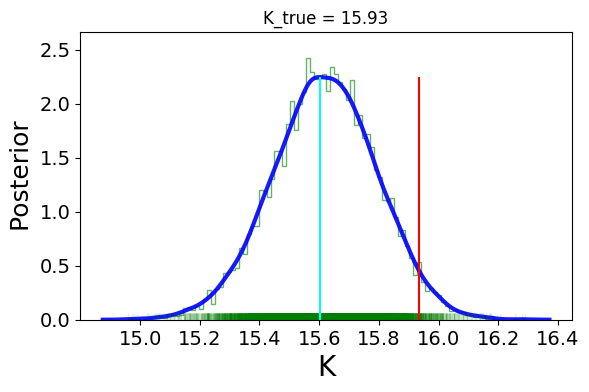

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


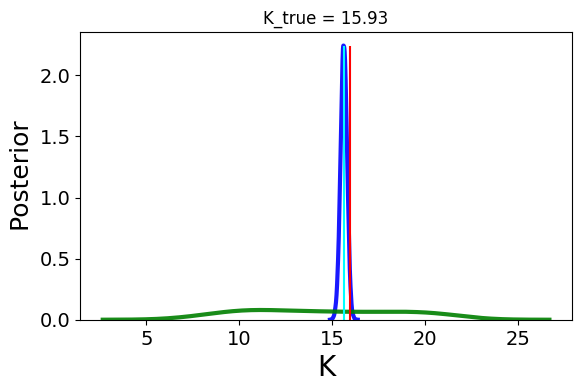

mean =  15.618913  std =  0.17543997


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 298846.03it/s]


------------------------------------------------------------
--- posterior sampling took: 0.03451800346374512 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


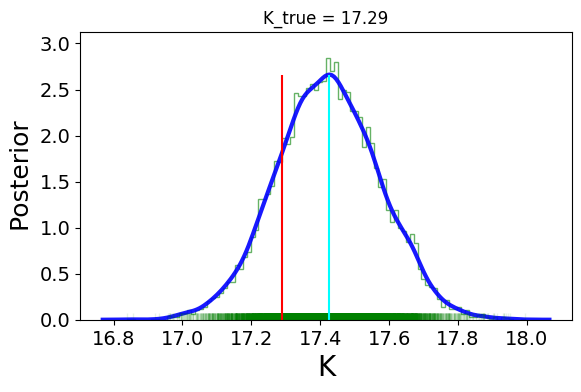

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


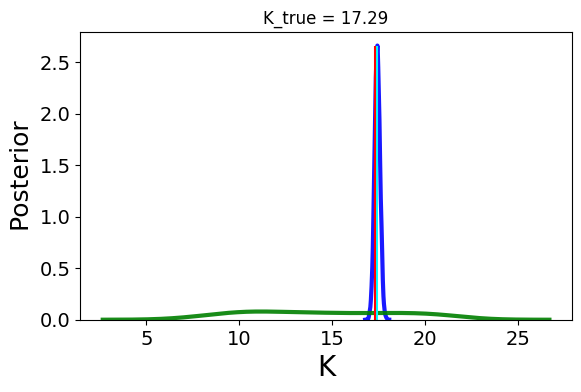

mean =  17.422443  std =  0.14999269


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 293480.37it/s]


------------------------------------------------------------
--- posterior sampling took: 0.03521990776062012 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


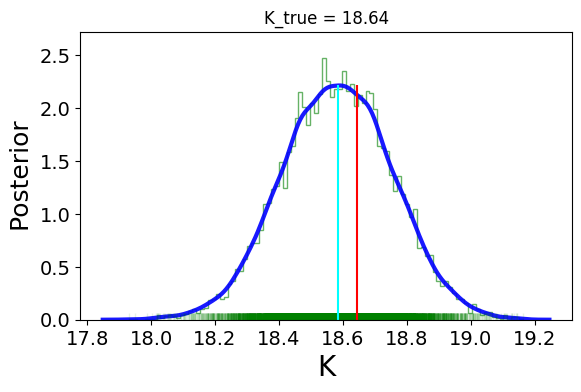

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


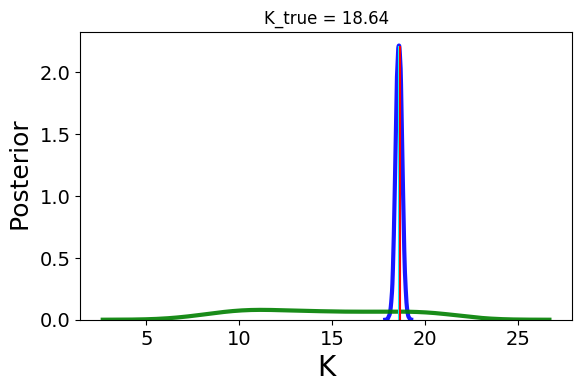

mean =  18.582157  std =  0.17231794


Drawing 10000 posterior samples: 11144it [00:00, 234990.84it/s]           


------------------------------------------------------------
--- posterior sampling took: 0.04852604866027832 seconds ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


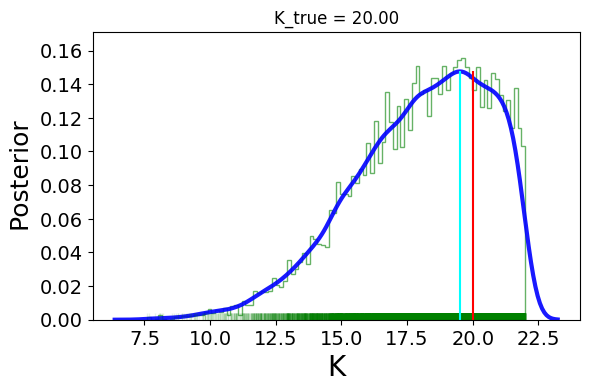

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


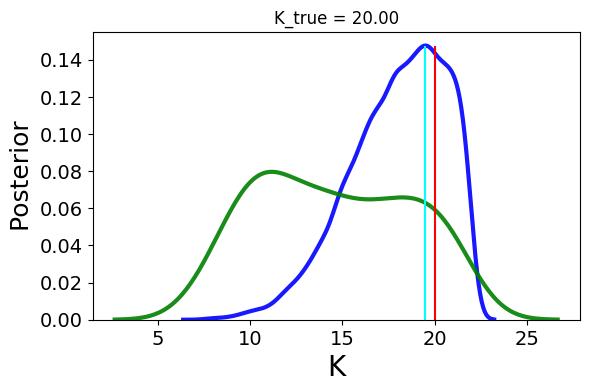

mean =  18.009487  std =  2.599341


In [22]:
K_true = np.linspace(7.8,20,10)
K_est_mean = []
K_est_std = []
for k in K_true:
    k_est_stat = Posterior_obs(K_true=k,plot = True)
    K_est_mean.append(k_est_stat[0])
    K_est_std.append(k_est_stat[1])
    print('mean = ',k_est_stat[0],' std = ', k_est_stat[1])

In [23]:
K_est_mean = np.array(K_est_mean)
K_est_std = np.array(K_est_std)

m =  0.9069784067782133 q =  1.0891805847781977


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


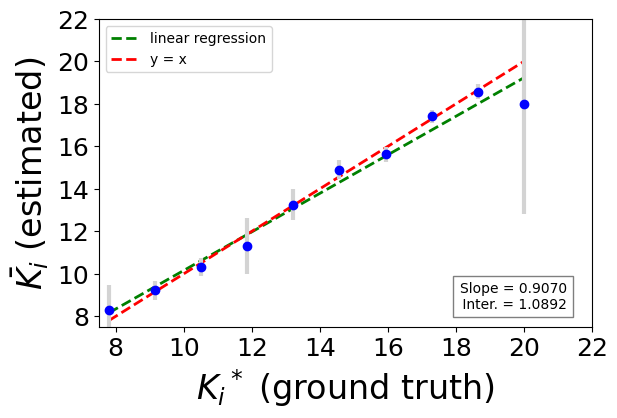

In [24]:
A = np.vstack([K_true, np.ones(len(K_true))]).T
m, q = np.linalg.lstsq(A, K_est_mean, rcond=None)[0]
print('m = ',m,'q = ',q)
plt.figure(figsize=(14,4))

plt.subplot(121);
plt.plot(K_true, m*K_true + q, '--g', lw=2,label='linear regression');
plt.plot(K_true, K_true, '--r', lw=2,label='y = x');

plt.errorbar(K_true, K_est_mean, yerr=2*K_est_std, fmt='o', color='b', ecolor='lightgray', elinewidth=3, capsize=0);


plt.ylabel(r"$\bar{K_i}$ (estimated)", fontsize=24)
plt.xlabel(r"${K_i}^*$ (ground truth)", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([7.5, 22, 7.5, 22])
plt.text(0.95, 0.05,f'Slope = {m:.4f}\n Inter. = {q:.4f}', ha='right', va='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
plt.legend()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir_reg),"SBI_linear_regression_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir_reg),"SBI_linear_regression_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".eps"), dpi=800)
plt.show()

In [25]:
post_std = np.std(K_est_mean, axis=0)
z_score = []
for i in range(0,len(K_true)):
    z_score.append(abs(K_est_mean[i]-K_true[i])/K_est_std[i])
z_score = np.array(z_score)

In [26]:
print(z_score)

[0.88275691 0.26733222 0.91369399 0.8208226  0.07514998 1.47555707
 1.79218361 0.89040674 0.36146736 0.76577598]


In [27]:
def shrinkage(prior_std, post_std):
    return 1 - (post_std / prior_std)**2

In [28]:
#prior_std = (np.sqrt(1/12*(prior_max[0] - prior_min[0])))
prior_std = np.std(prior_samples)
print(prior_std)
Shrin =[]
for i in range(0,len(K_est_std)):
    Shrin.append(shrinkage(prior_std = prior_std,post_std=K_est_std[i]))
Shrin = np.array(Shrin)
print(Shrin)

4.058444623142171
[0.97954283 0.99696754 0.99747759 0.97362491 0.99201193 0.99708544
 0.99813131 0.99863409 0.99819722 0.58978906]


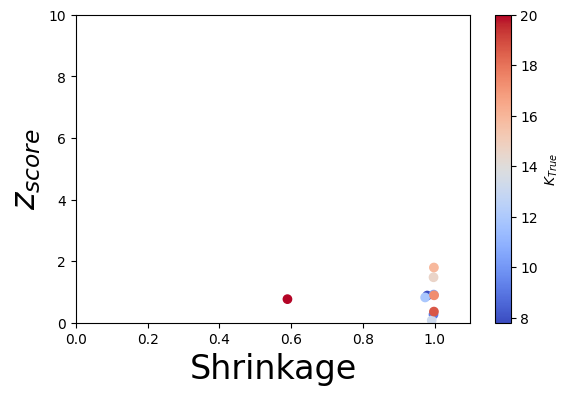

In [29]:
plt.figure(figsize=(14,4))
norm = mcolors.Normalize(vmin=np.min(K_true), vmax=np.max(K_true))
colors = np.linspace(0, 0.5, len(Shrin))
plt.subplot(121);
plt.ylabel(r"${z_{score}}$", fontsize=24)
plt.xlabel('Shrinkage', fontsize=24)
plt.scatter(Shrin, z_score,c=K_true, cmap='coolwarm',norm=norm);
plt.colorbar(label=r"${K_{True}}$")
plt.axis([0, 1.1, 0, 10])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir_reg),"SBI_shrin_zscore_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir_reg),"SBI_shrin_zscore_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".eps"), dpi=800)
plt.show()


In [30]:

def plot_time_series(K_true, K_mean):
    x_obs = Kbath_ode_model_jit(K_true)
    v_obs = x_obs[0:nt]
    r_obs = x_obs[nt:2*nt]
    x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), th= 0.00012,mode = mode)

    x_fit = Kbath_ode_model_jit(K_mean)
    v_fit = x_fit[0:nt]
    r_fit = x_fit[nt:2*nt]

    num_samples=10000
    posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()


    plt.figure(figsize=(10, 6))
    plt.suptitle(f'K_true = {K_true:.2f}; K_mean = {K_mean:.2f}')

    # Primo subplot
    ax1 = plt.subplot(211)
    ax1.plot(ts, v_obs, '.', markersize=4, color='blue', label='observed')
    ax1.plot(ts, v_fit, lw=2, color='cyan', label='ppc', alpha=0.5)
    ax1.set_xlabel('Time', fontsize=18)
    ax1.set_ylabel('Voltage v', fontsize=18)
    ax1.legend(loc='upper left', fontsize=14, fancybox=True, edgecolor='black')
    ax1.grid()
    
    # Secondo subplot
    ax2 = plt.subplot(212)
    ax2.plot(ts, r_obs, '.', markersize=4, color='red', label='hidden')
    ax2.plot(ts, r_fit, lw=2, color='yellow', label='ppc', alpha=0.5)
    ax2.set_xlabel('Time', fontsize=18)
    ax2.set_ylabel('Firing rate r', fontsize=18)
    ax2.legend(loc='upper left', fontsize=14, fancybox=True, edgecolor='black')
    ax2.grid()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(cwd+'/'+str(Res_dir_time_series), "time_series_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".png"), dpi=300)
    plt.savefig(os.path.join(cwd+'/'+str(Res_dir_time_series), "time_series_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".eps"), dpi=300)
    plt.show()


    plt.figure(figsize=(5, 5))
    plt.plot(r_obs, v_obs, 'b', linewidth=2, label='observed')
    plt.plot(r_fit, v_fit, 'r', linewidth=1, label='ppc', alpha=0.5)
    plt.ylabel('v', fontsize=18);
    plt.xlabel('r', fontsize=18);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper left', fontsize=14, fancybox=True, edgecolor='black')
    plt.grid()
    plt.tight_layout()
    plt.title(f'K_true = {K_true:.2f}; K_mean = {K_mean:.2f}')
    plt.savefig(os.path.join(cwd+'/'+str(Res_dir_time_series), "fitphaseplane_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".png"), dpi=300)
    plt.savefig(os.path.join(cwd+'/'+str(Res_dir_time_series), "fitphaseplane_"+str(num_sims)+"sims_"+"K_true="+str(K_true)+".eps"), dpi=300)
    plt.show()

    return x_obs,r_obs,posterior_samples,x_fit,r_fit

Drawing 10000 posterior samples: 11896it [00:00, 169172.64it/s]           
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


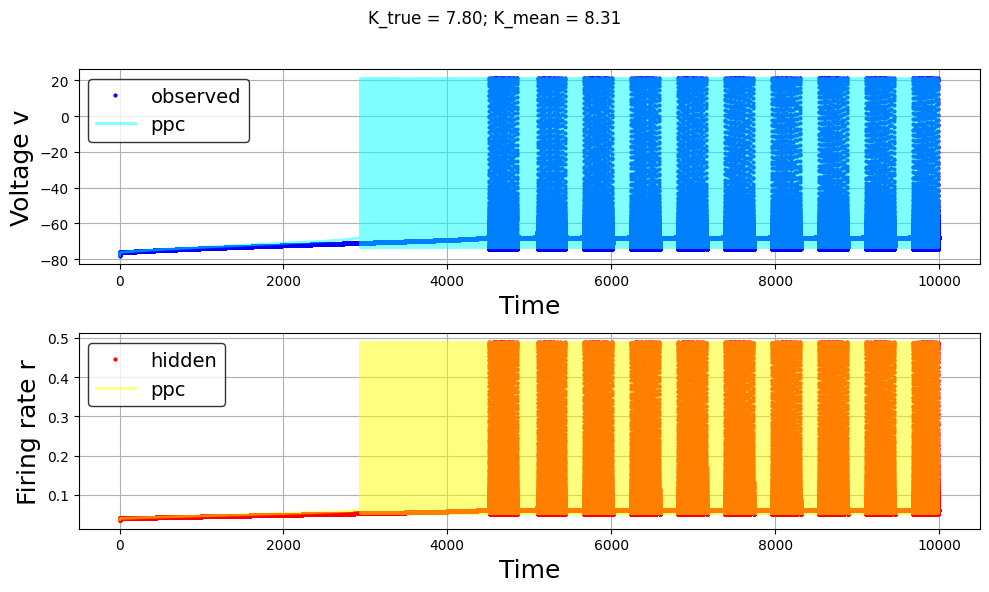

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


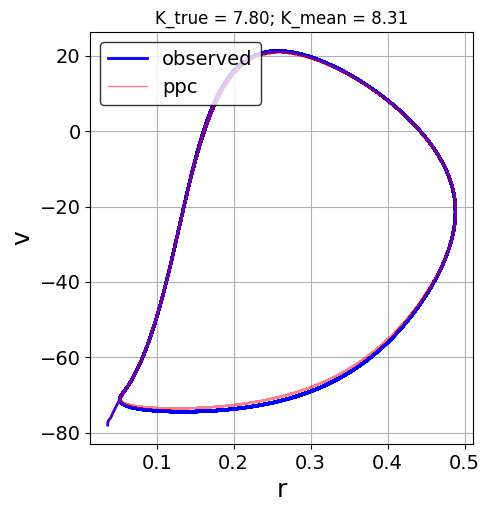

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 322393.25it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


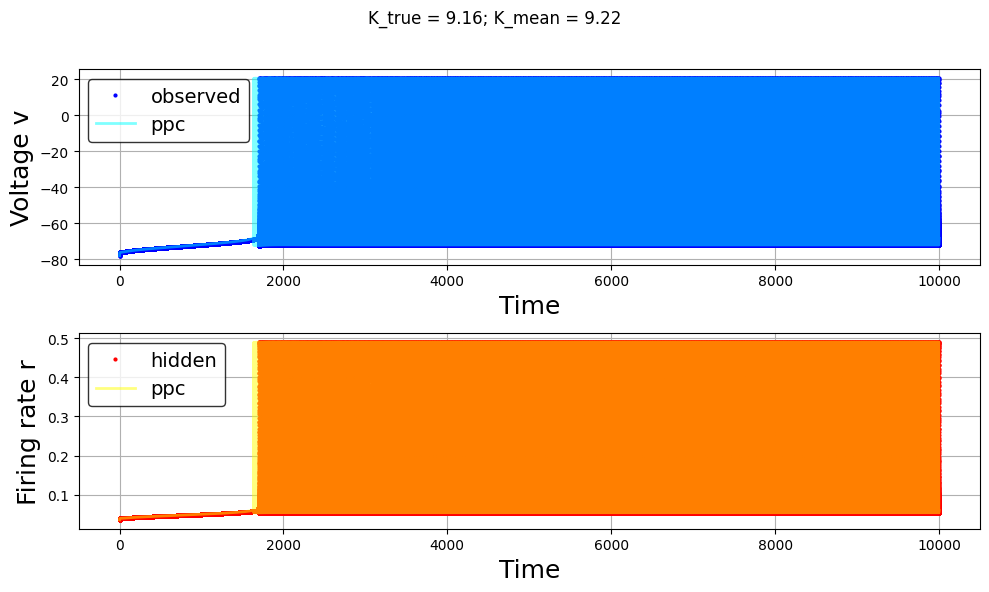

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


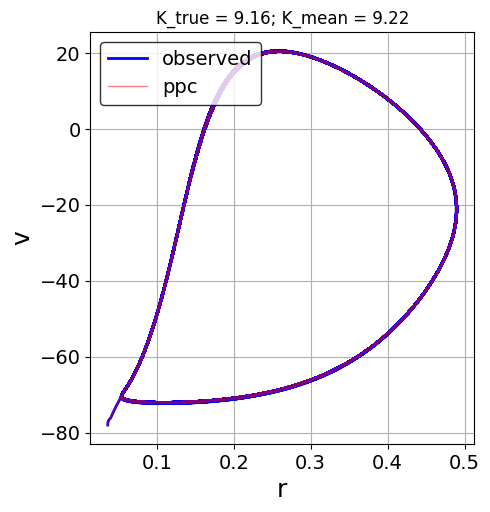

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 300301.00it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


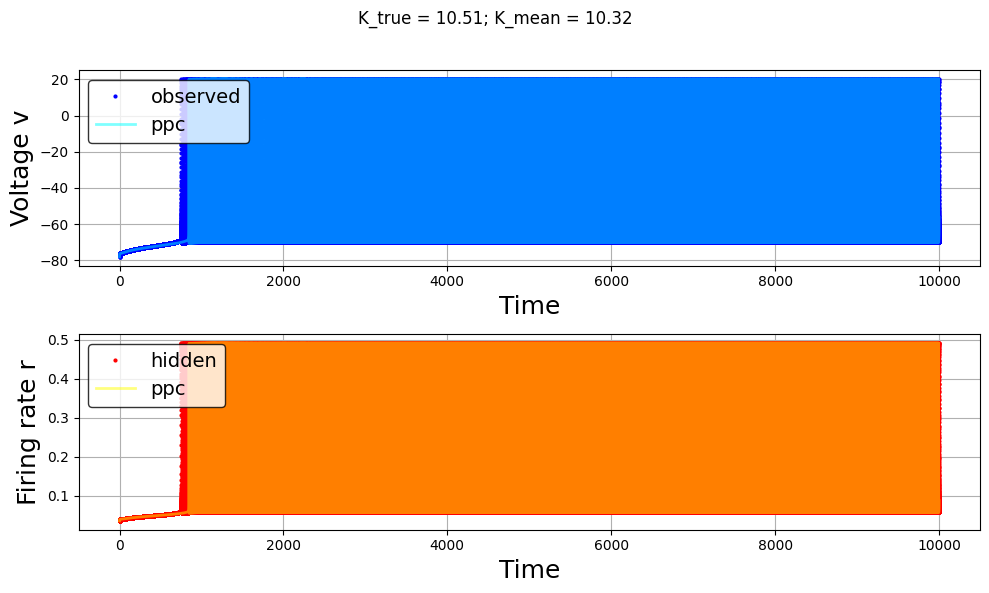

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


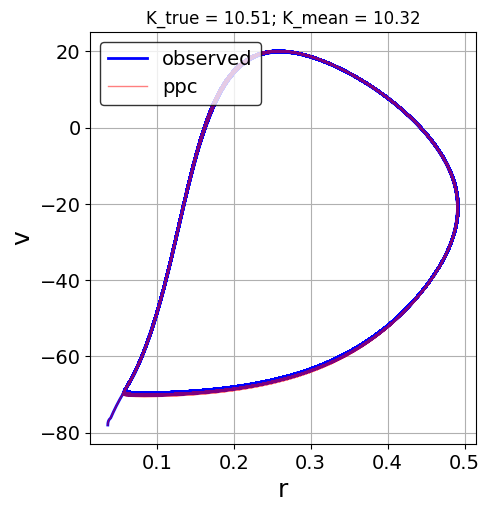

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 291909.66it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


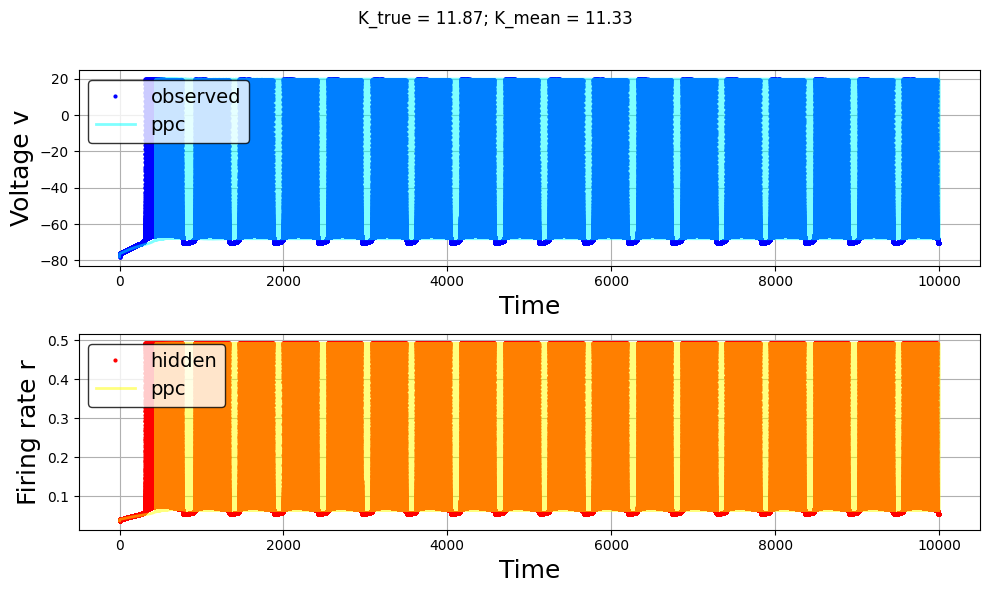

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


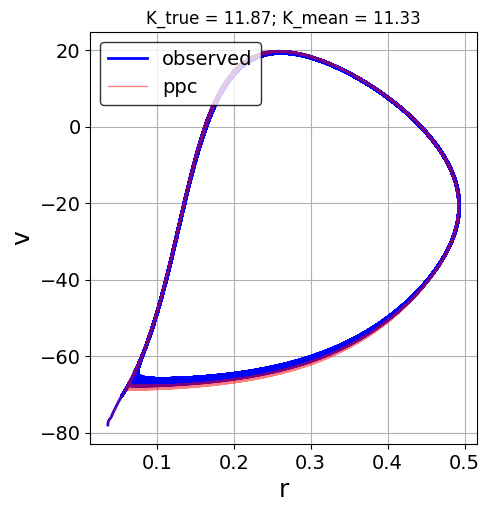

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 342621.51it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


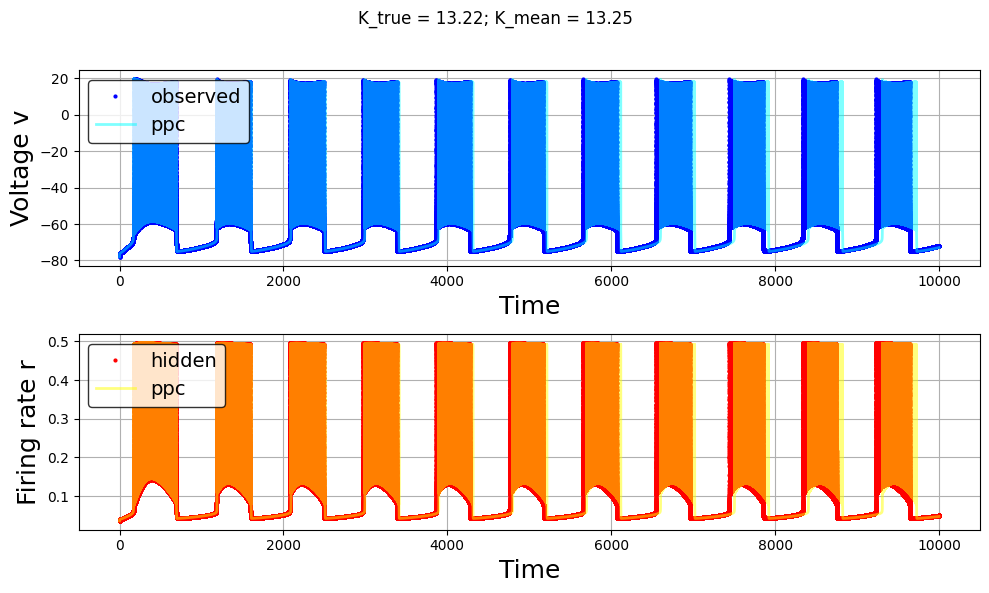

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


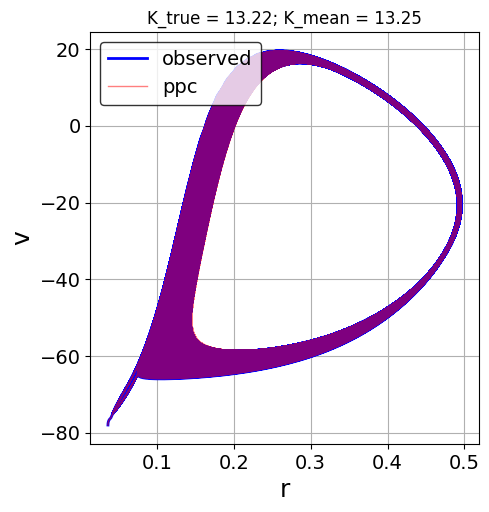

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 354758.01it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


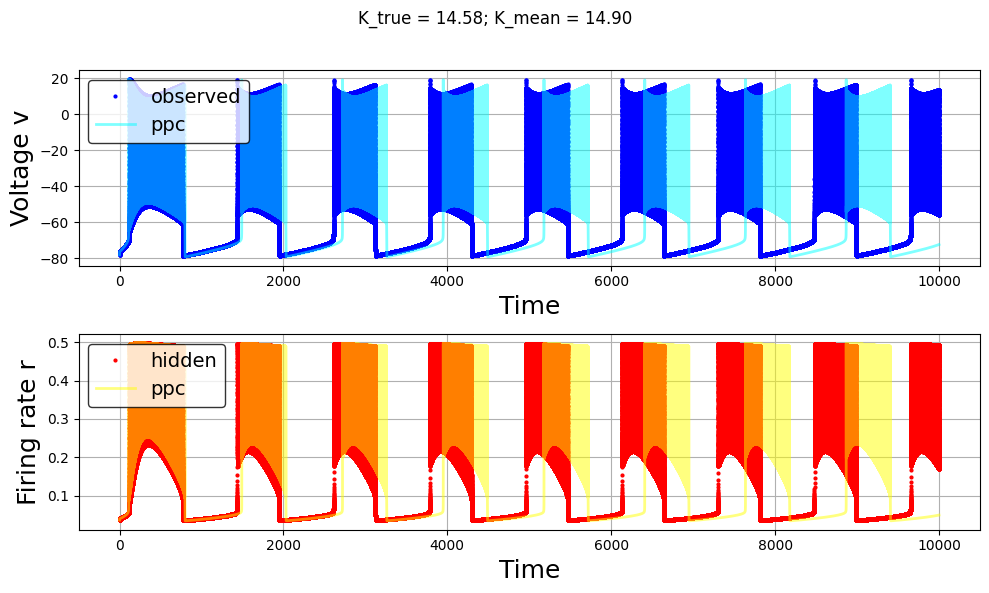

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


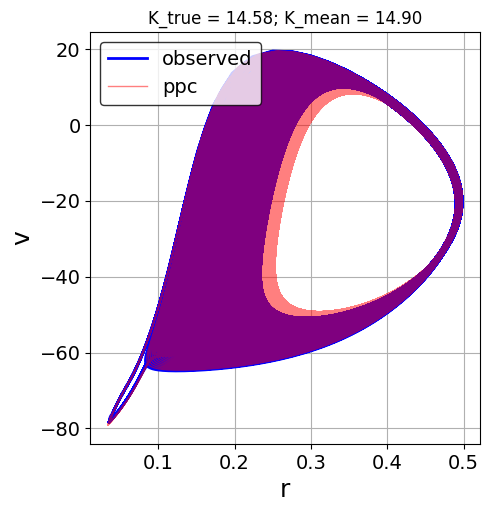

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 340170.64it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


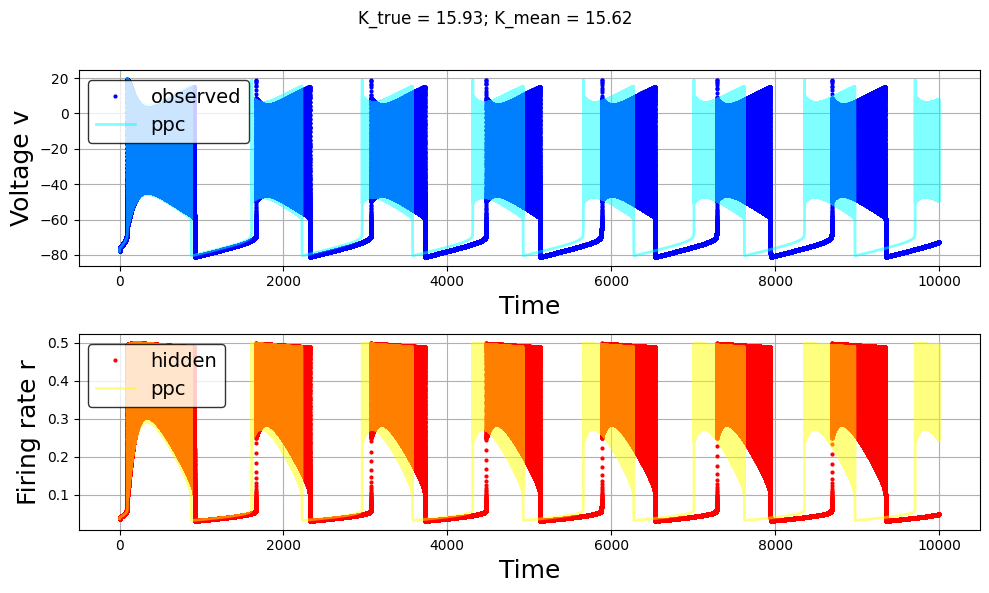

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


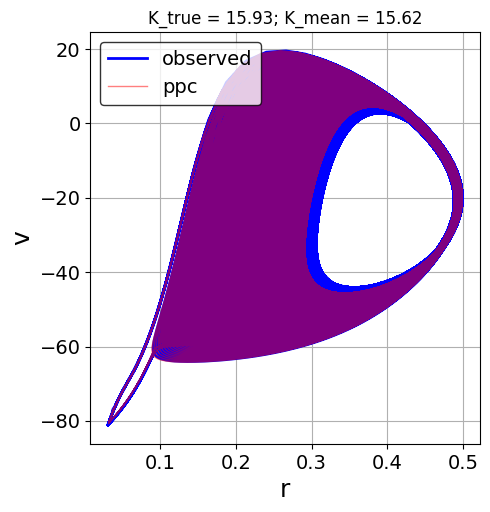

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 375332.58it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


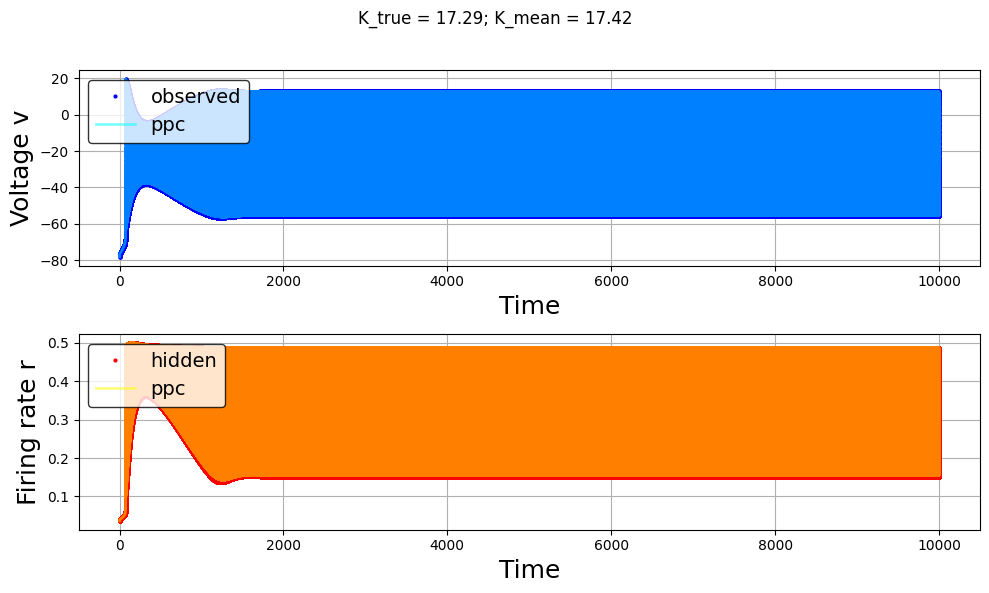

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


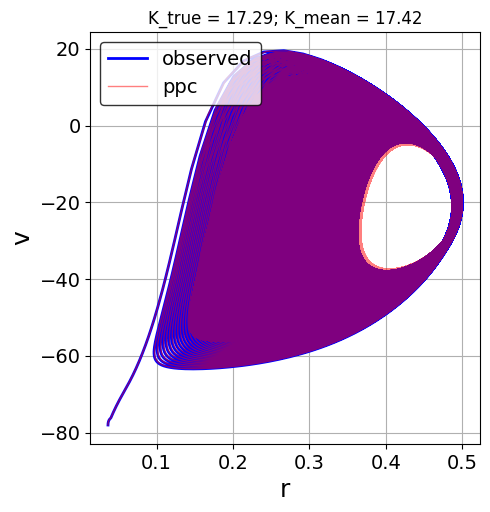

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 277307.52it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


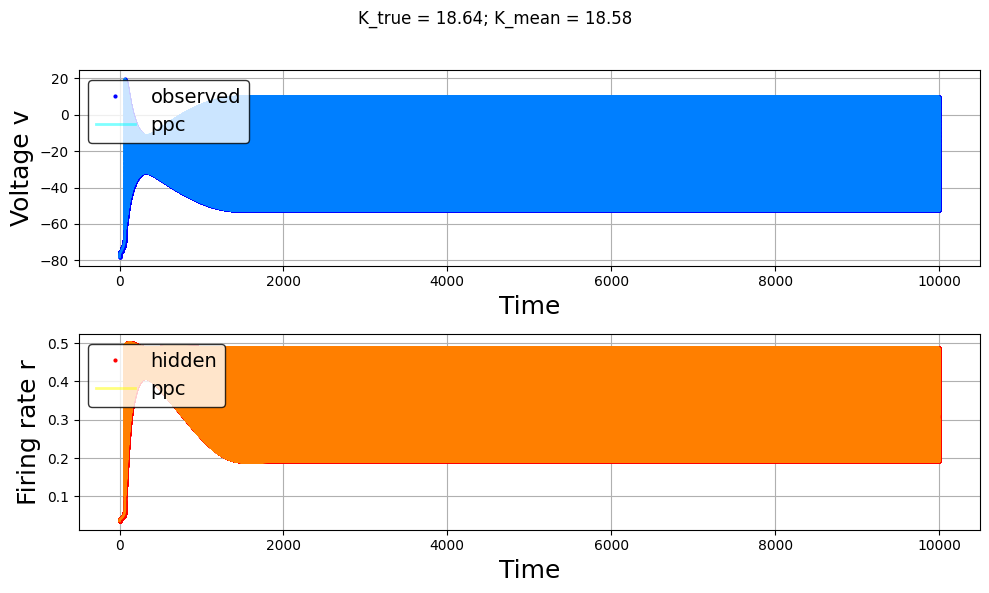

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


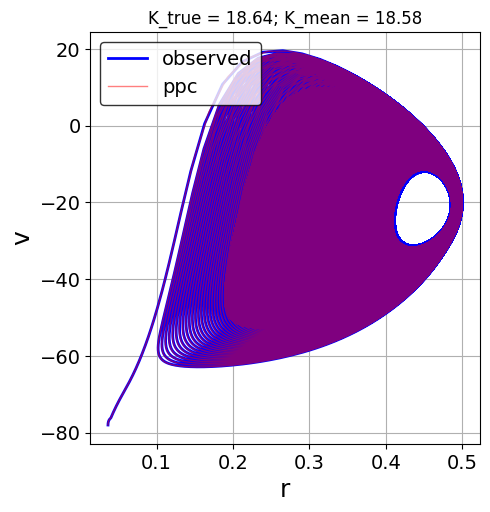

Drawing 10000 posterior samples: 11107it [00:00, 244286.32it/s]           
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


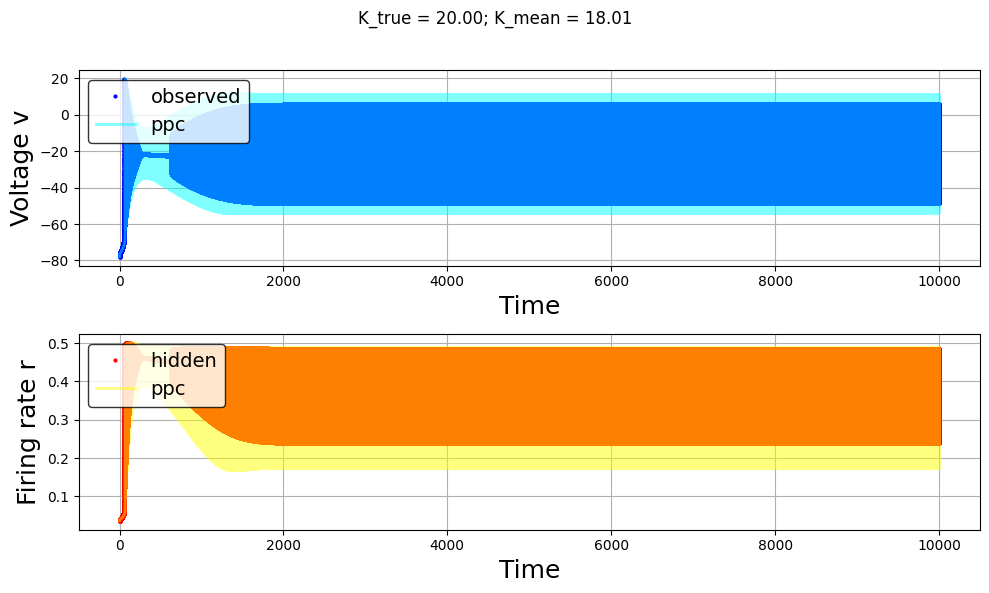

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


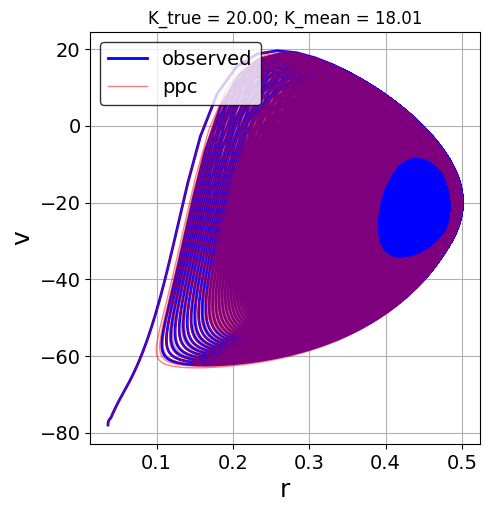

In [31]:
x_obs = {}
r_obs = {}
x_fit = {}
r_fit = {}
posterior_samples = {}
for i in range(0,len(K_true)):
    val = plot_time_series(K_true[i],K_est_mean[i])
    x_obs[str(K_true[i])] = val[0]
    r_obs[str(K_true[i])] = val[1]
    posterior_samples[str(K_true[i])] = val[2]
    x_fit[str(K_est_mean[i])] = val[3]
    r_fit[str(K_est_mean[i])] = val[4]

In [32]:
for i in range(0,len(K_true)):
   np.save(os.path.join(cwd+'/'+str(Res_dir_data), 'v_obs_ode_obsV'+str(num_sims)+"sims_"+"K_true="+str(K_true[i])+'.npy'), x_obs[str(K_true[i])])
   np.save(os.path.join(cwd+'/'+str(Res_dir_data), 'r_obs_ode_obsV'+str(num_sims)+"sims_"+"K_true="+str(K_true[i])+'.npy'), r_obs[str(K_true[i])])
   np.save(os.path.join(cwd+'/'+str(Res_dir_data), 'posterior_Kbath_ode_obsV_'+str(num_sims)+"sims_"+"K_true="+str(K_true)+'.npy'), posterior_samples[str(K_true[i])])
   np.save(os.path.join(cwd+'/'+str(Res_dir_data), 'v_fit_ode_fitV'+str(num_sims)+"sims_"+"K_true="+str(K_est_mean[i])+'.npy'), x_fit[str(K_est_mean[i])])
   np.save(os.path.join(cwd+'/'+str(Res_dir_data), 'r_fit_ode_fitV'+str(num_sims)+"sims_"+"K_true="+str(K_est_mean[i])+'.npy'), r_fit[str(K_est_mean[i])])